In [73]:
%matplotlib inline

def estimate__e_s(T): 
    from xray import ufuncs
    T0 = 273.15 ## Kelvin, reference temperature
    e_s = 611 * ufuncs.exp((17.67 * (T - T0)) / (T - 29.65) )
    return(e_s)

def estimate_p(h):
    p = 101325 * (1 - ((2.25577 * 10**-5) * h))**5.25588 ## Pascals 
    return(p)

def estimate_relative_humidity(q,e_s,p):
    ## estimates relative humidity using hypsometric equation for pressure, virtual temperature and 
    ## average temperature 
    import numpy as np
    w = q ## approximating the mixing ratio as the specific humidity
    w_s = 0.622 * (e_s / p)
    RH = 100.0 * (w / w_s)
    return (RH)

def estimate_emc(RH,T):
    if RH < 10: 
        EMC = 0.03229 + (0.281073 * RH) - (0.000578 * T * RH)
    elif RH >= 10 and RH <= 50:
        EMC = 2.22749 - 0.160107*RH - 0.014784*T
    else: 
        EMC = 21.0606 + (0.005565*(RH**2)) - (0.00035*RH*T) - (0.483199*RH)
    return(EMC)

def nfdrs_climate_class(lon):
    ## use eastern boundary of the Cascades to delineate (this might need refinement)
    if lon > -122.5:
        climate_class = 2
        wetrat = 0.25
    else:
        climate_class = 3
        wetrat = 0.05
    return(climate_class,wetrat)


In [74]:
## note this forcing data is for the entire CONUS so i need to mask out what isn't in the CRB 
## note: for masking, ufunc functions can be used directly on a DataArray
%load_ext autoreload
################################# INPUTS #############################
lat = 48.03125
lon = -121.28125
######################################################################
import numpy as np
import xray
from xray import ufuncs
import os
import math 
import gc 
import pandas as pd 
# from dfm_functions import estimate_emc, nfdrs_climate_class,estimate_relative_humidity
basin = "cascades"
model = "CCSM4"
scenario = "historical"

direc = '/raid/gergel/%s' % "tmin"
tmin_file = "%s_%s_%s.nc" % (model,scenario,"tasmin")
tmin_full = xray.open_dataset(os.path.join(direc,tmin_file)) ## load tmin

direc = '/raid/gergel/%s' % "tmax"
tmax_file = "%s_%s_%s.nc" % (model,scenario,"tasmax")
tmax_full = xray.open_dataset(os.path.join(direc,tmax_file)) ## load tmax

direc = '/raid/gergel/%s' % "rh"
sh_file = "%s_%s_%s.nc" % (model,scenario,"huss")
q_full = xray.open_dataset(os.path.join(direc,sh_file)) ## load specific humidity 

direc = '/raid/gergel/%s' % "precip"
pr_file = "%s_%s_%s.nc" % (model,scenario,"pr")
pr_full = xray.open_dataset(os.path.join(direc,pr_file)) ## load precip

## adjust lat/lon dimensions since the index names are different
tmin_lons_new = tmin_full['lon'].values[tmin_full['lon'].values > 180] - 360 
tmin_full['lon'] = tmin_lons_new
tmax_full['lon'] = tmin_lons_new
q_full['lon'] = tmin_lons_new 
pr_full['lon'] = tmin_lons_new

## select out gridcell 
lon_ind = np.where(np.asarray(tmin_full.lon).astype('|S10') == np.str(lon))[0][0]
lat_ind = np.where(np.asarray(tmin_full.lat).astype('|S8') == np.str(lat))[0][0]

## get julian days 
julians = pd.DatetimeIndex(np.asarray(pr_full.time)).dayofyear

# tmin = tmin_full[:,lat_ind,lon_ind]
tmin = tmin_full.isel_points(lon=[lon_ind],lat=[lat_ind])
tmax = tmax_full.isel_points(lon=[lon_ind],lat=[lat_ind])
q = q_full.isel_points(lon=[lon_ind],lat=[lat_ind])
pptamt = pr_full.isel_points(lon=[lon_ind],lat=[lat_ind])


del tmin_full,tmax_full, q_full,pr_full
gc.collect() 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


11072

In [75]:
t_avg = (tmin.air_temp_min + tmax.air_temp_max)/2.0

## get elevation of grid cell
from snowpack_functions import get_elev_for_lat_lon,import_gridcell_elevation 
soil_file = '/raid9/gergel/agg_snowpack/soil_avail.txt'
elev_corr_info = import_gridcell_elevation(soil_file) 
h = get_elev_for_lat_lon(elev_corr_info,lat,lon)

## get pressure 
p = estimate_p(h)

## get sat vap pressure
e_s = estimate__e_s(t_avg)
#e_s = estimate__e_s(tmin.air_temp_min) ## try using minimum air temperature rather than average 

## estimate relative humidity
RH = estimate_relative_humidity(q,e_s,p)

## if RH > 100, RH = 100
RH_new_vals = np.ndarray(shape=(1,len(RH.specific_humidity.values[0,:])),dtype='float')
for val in np.arange(len(RH.specific_humidity.values[0,:])):
    if RH.specific_humidity.values[0,val] > 100:
        RH_new_vals[0,val] = 100
    else:
        RH_new_vals[0,val] = RH.specific_humidity.values[0,val]
RH.specific_humidity.values = RH_new_vals

## estimate vapor pressures
satvpd = e_s ## this was already calculated
satvpx = estimate__e_s(tmax.air_temp_max)
satvpn = estimate__e_s(tmin.air_temp_min)

ambvp = (RH * satvpd) / 100.0
RHmax = 100.0 * (ambvp/satvpn)
RHmin = 100.0 * (ambvp/satvpx)

## if RHmax > 100, RHmax = 100
RHmax_new_vals = np.ndarray(shape=(1,len(RHmax.specific_humidity.values[0,:])),dtype='float')
for val in np.arange(len(RHmax.specific_humidity.values[0,:])):
    if RHmax.specific_humidity.values[0,val] > 100:
        RHmax_new_vals[0,val] = 100
    else:
        RHmax_new_vals[0,val] = RHmax.specific_humidity.values[0,val]
RHmax.specific_humidity.values = RHmax_new_vals

## get climate class and rainfall rate 
climat,wetrat = nfdrs_climate_class(lon)
pptamt_in = pptamt * 0.0393701 ## convert from mm to inches 
pptdur = ufuncs.rint((pptamt_in/wetrat) + 0.49)

## convert temps to Fahrenheit (this is required for EMC calculations developed by Simard 1968)
# ºF =(K - 273.15)* 1.8000 + 32.00
tmin['air_temp_min'].values = ((tmin.air_temp_min.values - 273.15) * 1.8) + 32.0
tmax['air_temp_max'].values = ((tmax.air_temp_max.values - 273.15) * 1.8) + 32.0
t_avg.values = ((t_avg.values - 273.15) * 1.8) + 32.0

## estimate EMCs
EMCmin = estimate_emc(RHmin,tmax.air_temp_max)
#EMC = estimate_emc(RH,t_avg)
EMC = estimate_emc(RH,tmin.air_temp_min)
#EMC = EMCmin
# EMCmin = EMC
EMCmax = estimate_emc(RHmax,tmin.air_temp_min)
# EMCMAX = 0.15

phi = lat * 0.01745 ## lat is in degrees 
decl = 0.41008*np.sin((julians-82) * 0.01745)
daylit = 24 * (1.0 - ((np.arccos(np.tan(np.deg2rad(phi)) * np.tan(decl))) / math.pi))

EMCbar = ((daylit * EMCmin) + (24 - daylit) * EMCmax) / 24.0 

'''bndryh = ((24.0 - pptdur.precipitation) * (EMCbar.specific_humidity + pptdur.precipitation) * 
          (0.5 * pptdur.precipitation + 41.0 ) )/ 24.0 '''

bndryh = ( ( (24.0 - pptdur.precipitation) * EMCbar.specific_humidity) + pptdur.precipitation * 
          ( (0.5 * pptdur.precipitation) + 41.0 ) )/ 24.0 

################################################ calculate 100-hr timelag ######################################## 

## to initialize YMC100 at the beginning of a period
YMC100_0 = 5.0 + (5.0 * climat)

arr_mc100 = np.ndarray(shape=(len(julians)),dtype='float')

for day in np.arange(len(julians)):
    if day == 0:
        YMC100 = YMC100_0
    else: 
        YMC100 = arr_mc100[day-1]
    arr_mc100[day] = YMC100 + (np.float(bndryh.values[0,day]) - YMC100) * (1.0 - (0.87 * np.exp(-0.24) ) )

In [78]:
#print(np.max(arr_mc100))
print(arr_mc100[7:10])
print(bndryh[0,7:10])
'''print(EMCbar.specific_humidity.values[0,7:10])
print(EMCmin.specific_humidity.values[0,7:10])
print(EMCmax.specific_humidity.values[0,7:10])'''

[ 21.82107447  21.04857883  20.76245634]
<xray.DataArray (time: 3)>
array([ 20.17890179,  19.37363145,  20.14207731])
Coordinates:
    points   int64 0
  * time     (time) datetime64[ns] 1950-01-08 1950-01-09 1950-01-10
    lat      float64 48.03
    lon      float64 -121.3


'print(EMCbar.specific_humidity.values[0,7:10])\nprint(EMCmin.specific_humidity.values[0,7:10])\nprint(EMCmax.specific_humidity.values[0,7:10])'

saving figure to '/raid9/gergel/agg_snowpack/dfm_gridcell'


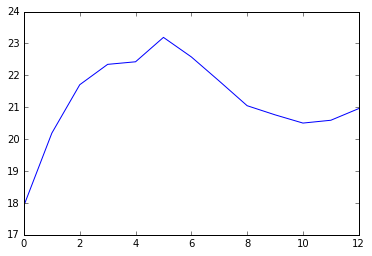

In [80]:
import matplotlib.pyplot as plt
'''ds_dfm = xray.DataArray(arr_mc100)
ds_dfm.time = tmin['time'].values
dfm_sel = ds_dfm.sel(time=slice('1981-02-01', '1981-06-01'))
dfm_sel['dead_fuel_moistue_100hr'].plot()'''
f = 10958 + 366
l = 10958 + 366 + 364
plt.plot(np.asarray(arr_mc100)[0:13])
#plt.plot(np.asarray(arr_mc100)[:])

## save plot
direc = '/raid9/gergel/agg_snowpack/'
plotname = 'dfm_gridcell' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath)